In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
# 한글 폰트 설정 (Windows + 나눔글꼴 설치 기준)
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv("TGDT_per_movie_data_cleaned_plus_feature.csv")

In [4]:
# 모델링용 피처 선택
features = [
    'log_salesAmt','log_showCnt', 'log_scrnCnt', 'showTm',
    'sales_per_screen','sales_per_show','screen_per_show',
    'has_main_director', 'has_main_actor', 
    'has_main_genre',
     'log_google_trend_ratio', 'plot_sentiment_score'
]

In [16]:
# 결측 제거 후 데이터 분할
df_model = df.dropna(subset=features + ['log_누적관람객수'])
X = df_model[features]
y = df_model['log_누적관람객수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# LightGBM
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

# CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 759, number of used features: 12
[LightGBM] [Info] Start training from score 11.699509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [18]:
def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<15} RMSE: {rmse:.3f} | R²: {r2:.3f}")

In [ ]:
# 성능 비교
eval_model("XGBoost", y_test, xgb_preds)
eval_model("LightGBM", y_test, lgb_preds)
eval_model("CatBoost", y_test, cat_preds)
eval_model("Random Forest", y_test, rf_preds)

XGBoost         RMSE: 1.957 | R²: 0.252
LightGBM        RMSE: 1.874 | R²: 0.314
CatBoost        RMSE: 1.812 | R²: 0.359
Random Forest   RMSE: 1.765 | R²: 0.392


In [20]:
def plot_feature_importance(model, name, feature_names):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:15]
    plt.figure(figsize=(8, 6))
    plt.title(f"Feature Importance: {name}")
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


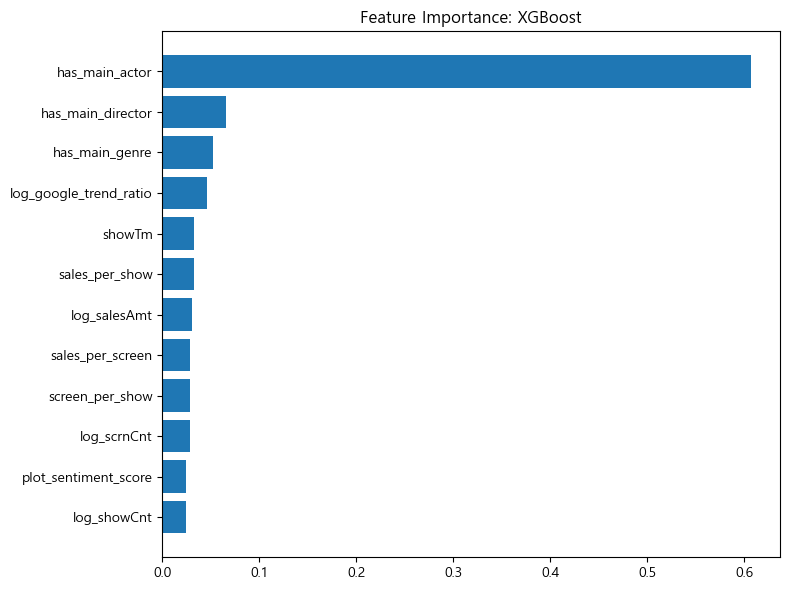

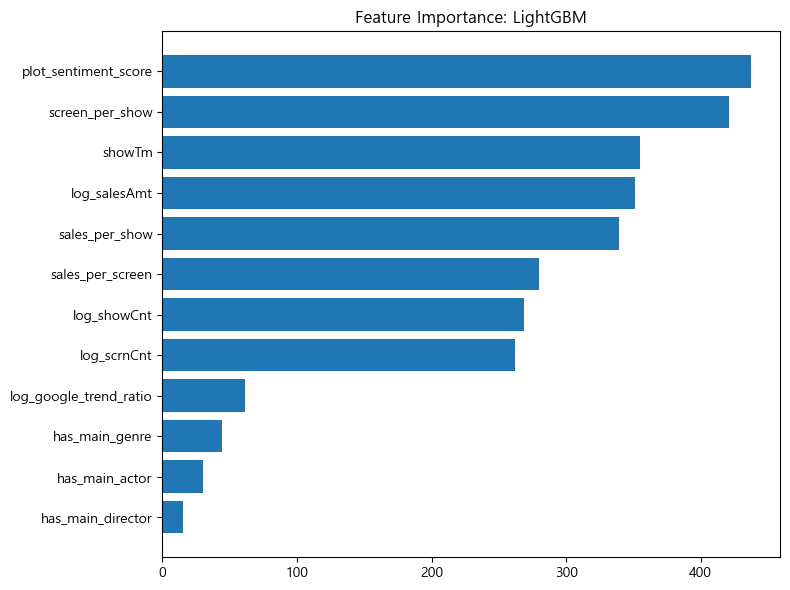

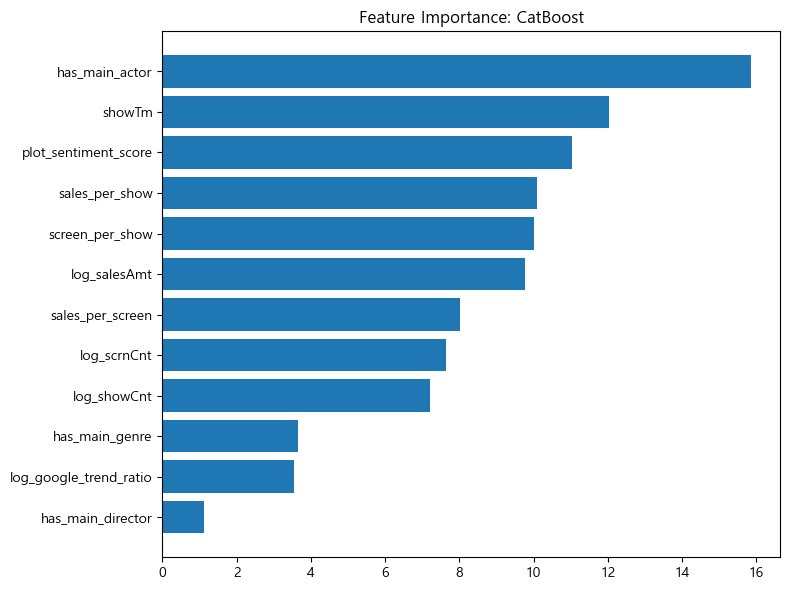

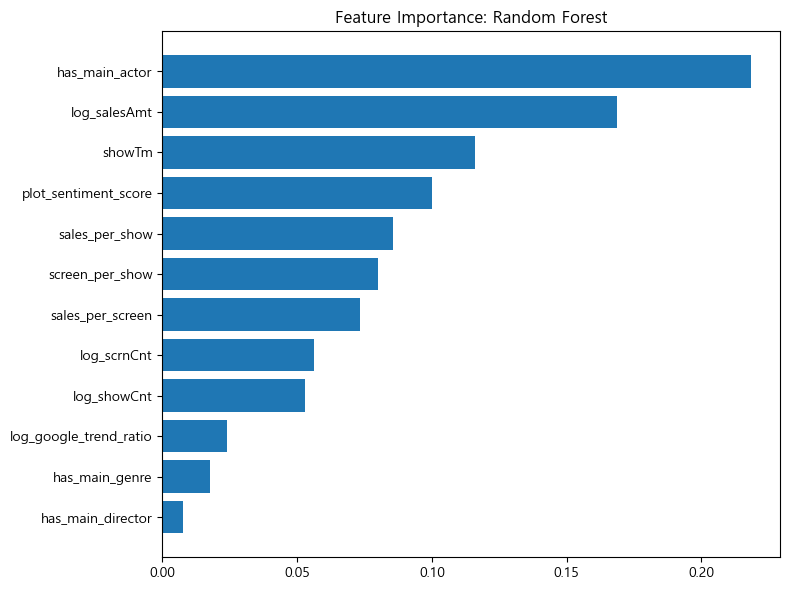

In [21]:
# 중요도 시각화 (XGBoost 제외 나머지 3개)
plot_feature_importance(xgb_model, "XGBoost", X_train.columns)
plot_feature_importance(lgb_model, "LightGBM", X_train.columns)
plot_feature_importance(cat_model, "CatBoost", X_train.columns)
plot_feature_importance(rf_model, "Random Forest", X_train.columns)

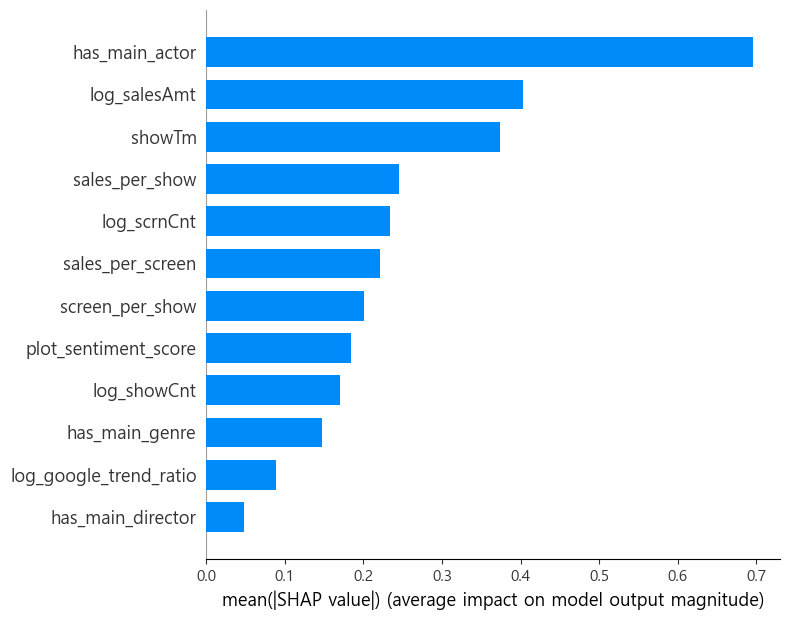

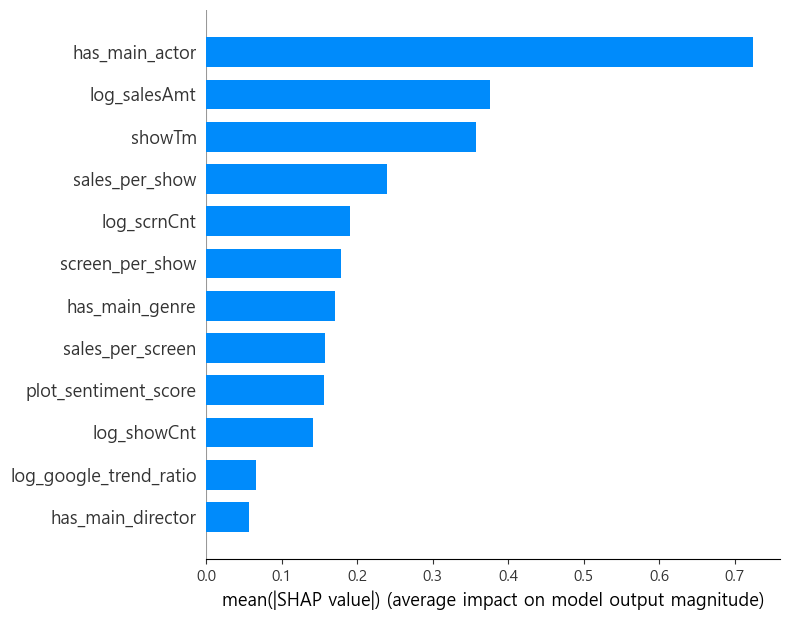

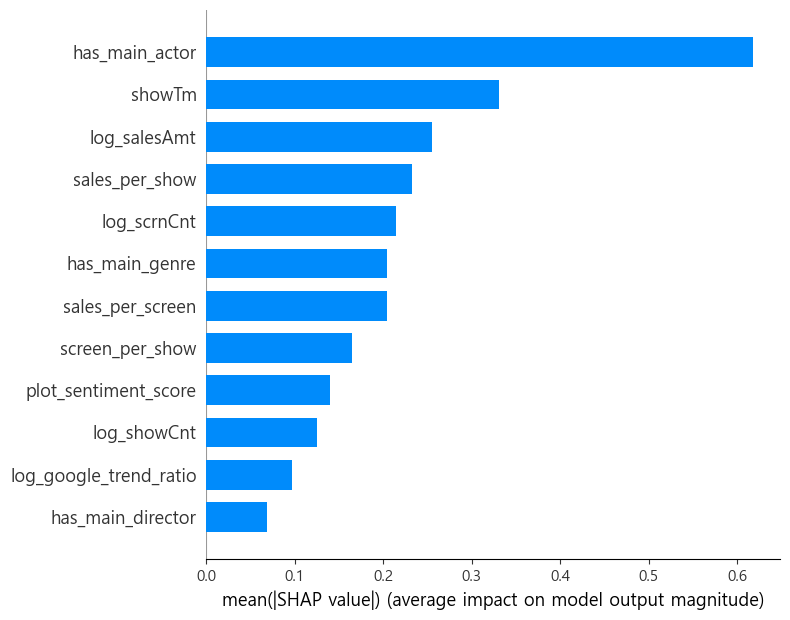

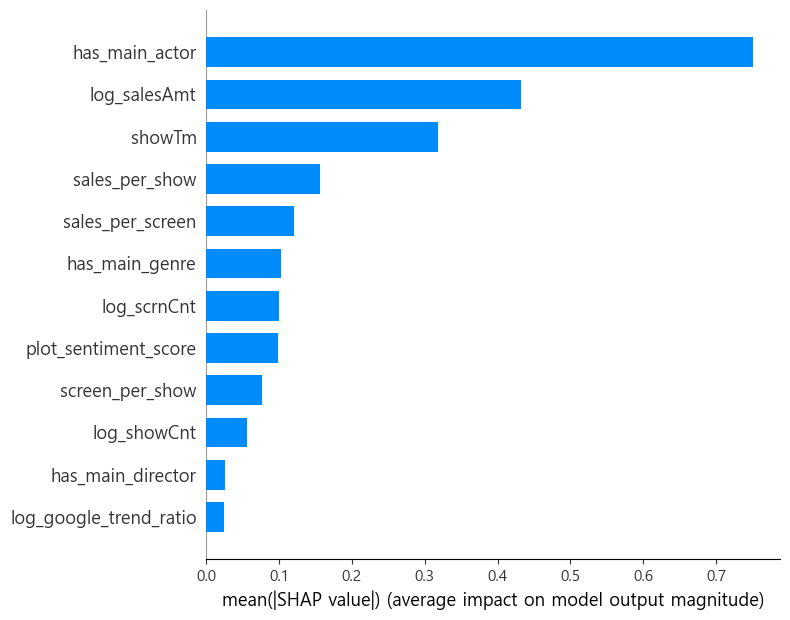

In [ ]:
import shap

# 각 모델 별 SHAP 값 계산
shap_values_xgb = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap_values_lgb = shap.TreeExplainer(lgb_model).shap_values(X_test)
shap_values_cat = shap.TreeExplainer(cat_model).shap_values(X_test)
shap_values_rf = shap.TreeExplainer(rf_model).shap_values(X_test)

# 모델 별 SHAP 값 시각화
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", title="XGBoost SHAP Values")
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar", title="LightGBM SHAP Values")
shap.summary_plot(shap_values_cat, X_test, plot_type="bar", title="CatBoost SHAP Values")
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", title="Random Forest SHAP Values")